In [2]:
%matplotlib inline

In [3]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

torch.manual_seed(1)

Create the model:



In [4]:
class LSTMTagger(nn.Module):

    def __init__(self, input_dim, hidden_dim, tagset_size):
        super(LSTMTagger, self).__init__()
        self.hidden_dim = hidden_dim

        # The LSTM takes word embeddings as inputs, and outputs hidden states
        # with dimensionality hidden_dim.
        self.lstm = nn.LSTM(input_dim, hidden_dim)

        # The linear layer that maps from hidden state space to tag space
        self.hidden2tag = nn.Linear(hidden_dim, tagset_size)

    def forward(self, data):
        lstm_out, _ = self.lstm(data.view(len(data), 1, -1))
        tag_space = self.hidden2tag(lstm_out.view(len(data), -1))
        tag_scores = F.log_softmax(tag_space, dim=1)
        return tag_scores
    
INPUT_DIM = 4
HIDDEN_DIM = 6
TARGET_SIZE = 4

In [6]:
# from torchviz import make_dot

# model = LSTMTagger(INPUT_DIM, HIDDEN_DIM, TARGET_SIZE)
# y = model(data15[0:1,])
# make_dot(y.mean(), params=dict(model.named_parameters()))

NameError: name 'data15' is not defined

Load the data, label the data, and prepare the data for LSTM

In [5]:
import sys
sys.path.insert(0, '../')

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from denoise import pv_det_sea

path_15 = '../dataset/pv/swallow/15times.txt'
path_12 = '../dataset/pv/swallow/12times.txt'
path_9 = '../dataset/pv/swallow/9times.txt'

max_time = 20
max_amp = 65

y_interval = np.around(max_amp, -1)/3

def load(path):
    data = pd.read_csv(path,
                       skiprows=6,
                       delimiter='\t').to_numpy()
    timestamp = data[:, 0]-data[0, 0]-8
    fs = 1000.
    pv = data[:, 1:-1]
    pv_det = pv_det_sea(pv=pv,
                        fs=fs,
                        denoise_len_s=0.2)
    return timestamp, pv_det

# data15
timestamp_xv, xv = load(path_15)
data15=torch.from_numpy(xv[8000:28000,].astype('float32'))

#labeling: no movement=0, open mouth=1, chewing=2, swallowing=3
target15=torch.cat((torch.zeros(2500),
                    torch.ones(2400),
                    2*torch.ones(9800),
                    3*torch.ones(3000),
                    torch.zeros(2300)),
                    0).type(torch.LongTensor)

# data12
timestamp_xii, xii = load(path_12)
data12=torch.from_numpy(xii[8000:28000,].astype('float32'))
target12=torch.cat((torch.zeros(2500),
                    torch.ones(2400),
                    2*torch.ones(8000),
                    3*torch.ones(3500),
                    torch.zeros(3600)),
                    0).type(torch.LongTensor)

# data9
timestamp_ix, ix = load(path_9)
data9=torch.from_numpy(ix[8000:28000,].astype('float32'))
target9=torch.cat((torch.zeros(2500),
                    torch.ones(2400),
                    2*torch.ones(6300),
                    3*torch.ones(3750),
                    torch.zeros(5050)),
                    0).type(torch.LongTensor)



Pass single dataset to test the LSTM functioning

In [19]:
model = LSTMTagger(INPUT_DIM, HIDDEN_DIM, TARGET_SIZE)
loss_function = nn.NLLLoss()
optimizer = optim.SGD(model.parameters(), lr=0.1)

# See what the scores are before training
# Note that element i,j of the output is the score for tag j for word i.
# Here we don't need to train, so the code is wrapped in torch.no_grad()
with torch.no_grad():
    inputs = data15
    tag_scores = model(inputs)
    print(tag_scores.size())


torch.Size([20000, 4])


Train the model:



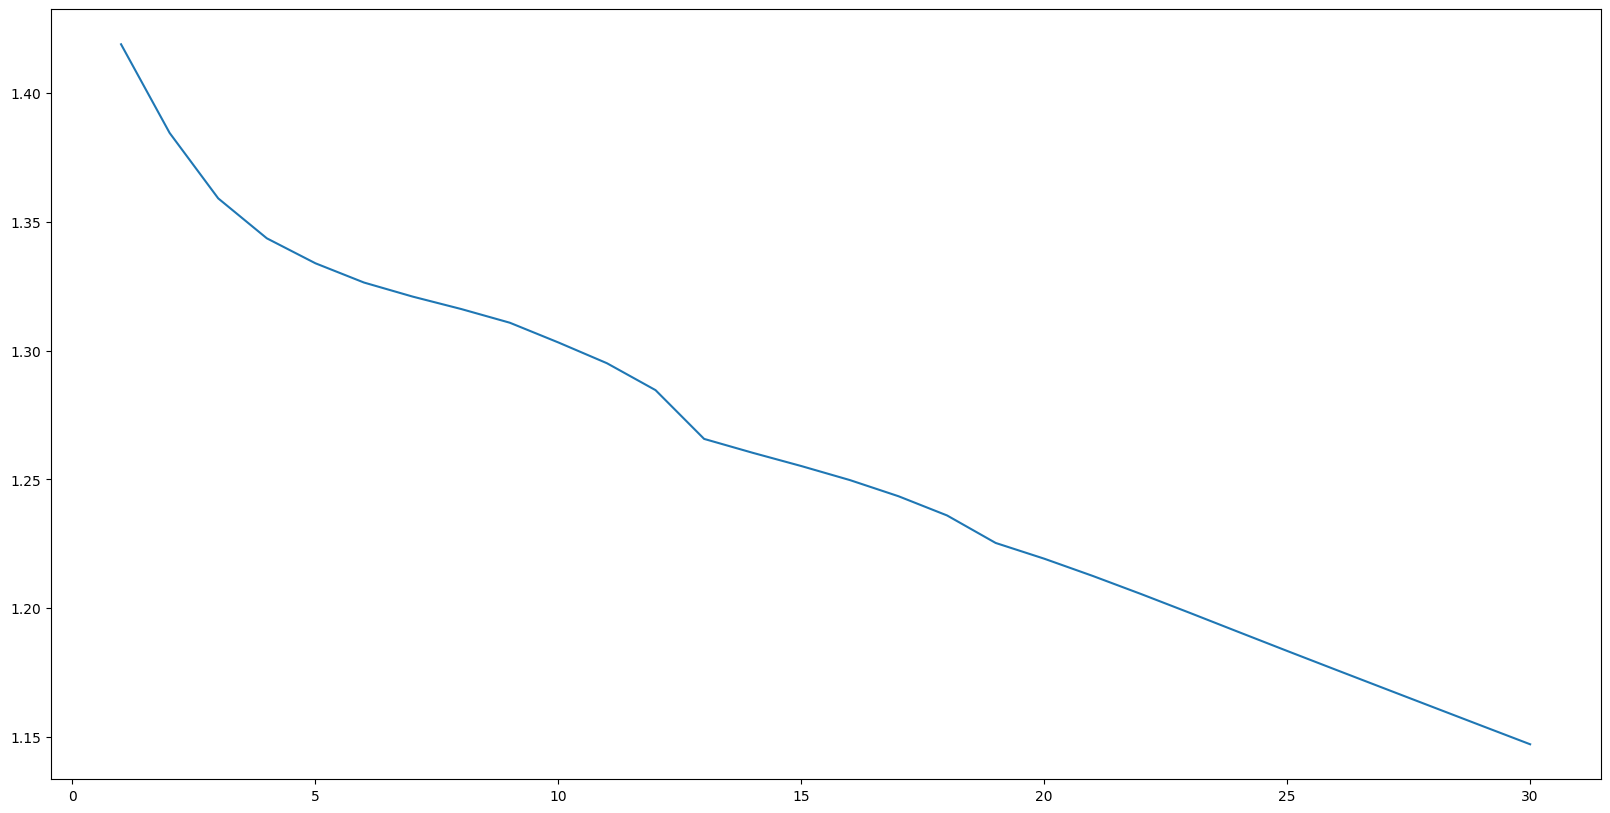

In [20]:
losses = []
epochs = []
train = [data15, data12]
labels = [target15, target12]
test = data9
for epoch in range(30):  
    for data, label in zip(train, labels):    
        # Step 1. Remember that Pytorch accumulates gradients.
        # We need to clear them out before each instance
        model.zero_grad()

        # Step 2. Run our forward pass.
        tag_scores = model(data)

        # Step 3. Compute the loss, gradients, and update the parameters by
        #  calling optimizer.step()
        loss = loss_function(tag_scores, label)
        loss.backward()

        optimizer.step()

    #record the test error value for each epoch    
    with torch.no_grad():
             tag_scores = model(test)
             test_loss = loss_function(tag_scores, target9)
             losses.append(test_loss.item())
             epochs.append(epoch+1)

fig, axes = plt.subplots(nrows=1,ncols=1)
fig.set_size_inches(20, 10)

axes.plot(epochs, losses)
# See what the scores are after training
# with torch.no_grad():
#     inputs = prepare_sequence(training_data[0][0], word_to_ix)
#     tag_scores = model(inputs)

#     # The sentence is "the dog ate the apple".  i,j corresponds to score for tag j
#     # for word i. The predicted tag is the maximum scoring tag.
#     # Here, we can see the predicted sequence below is 0 1 2 0 1
#     # since 0 is index of the maximum value of row 1,
#     # 1 is the index of maximum value of row 2, etc.
#     # Which is DET NOUN VERB DET NOUN, the correct sequence!
#     print(tag_scores)

In [21]:
result = model(data9)
result

tensor([[-1.2426, -1.9674, -1.0180, -1.5597],
        [-1.2258, -2.0074, -1.0099, -1.5709],
        [-1.2158, -2.0235, -0.9990, -1.5940],
        ...,
        [-1.0541, -2.0690, -1.0645, -1.7133],
        [-1.0538, -2.0690, -1.0648, -1.7133],
        [-1.0534, -2.0690, -1.0651, -1.7134]], grad_fn=<LogSoftmaxBackward0>)